In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.2.0
sys.version_info(major=3, minor=7, micro=8, releaselevel='final', serial=0)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [6]:
import pprint
pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [7]:
from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)


In [20]:
# tf.nn.softplus: log(1+e^x)
customized_softplus = keras.layers.Lambda(lambda x: tf.nn.softplus(x))
print(customized_softplus([-10., -5., 0., 5., 10.]))


tf.Tensor([4.5417706e-05 6.7153489e-03 6.9314718e-01 5.0067153e+00 1.0000046e+01], shape=(5,), dtype=float32)


In [21]:
# customeized dense layer
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        """构建所需要的参数"""
        print("building...")
        # x * w + b. input_shape:[None, a] [a, b] output_shape: [None, b]
        self.kernal = self.add_weight(name = "kernal", 
                                      shape = (input_shape[1], self.units),
                                     initializer = "uniform",
                                     trainable = True)
        self.bias = self.add_weight(name='bias', 
                                   shape = (self.units, ),
                                   initializer = 'zeros',
                                   trainable = True)
        super(CustomizedDenseLayer, self).build(input_shape)
        
    def call(self, x):
        """完成正向计算"""
        return self.activation(x @ self.kernal + self.bias)

model = keras.models.Sequential([
   CustomizedDenseLayer(units=30, activation='relu', input_shape=x_train.shape[1:]),
   CustomizedDenseLayer(units=1),
    customized_softplus
])


model.summary()
model.compile(loss="mean_squared_error", optimizer="adam")
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

building...
building...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer_6 (Cu (None, 30)                270       
_________________________________________________________________
customized_dense_layer_7 (Cu (None, 1)                 31        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(x_train_scaled, y_train,
                   validation_data = (x_valid_scaled, y_valid),
                   epochs=100,
                   callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 0s 1ms/step - loss: 1.2933 - val_loss: 0.5837
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4661 - val_loss: 0.4524
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4140 - val_loss: 0.4218
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4020 - val_loss: 0.4157
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3954 - val_loss: 0.4067
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3891 - val_loss: 0.4037
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3859 - val_loss: 0.3957
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3824 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3783 - val_loss: 0.3907
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3752 - val_lo

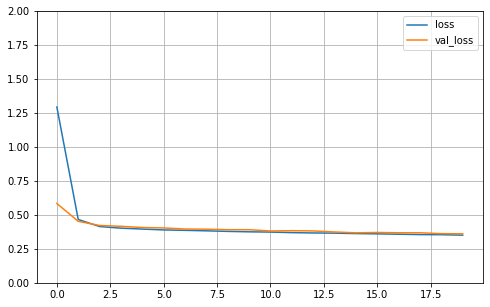

In [23]:
def plot_learn_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 2)
    plt.show()
plot_learn_curves(history)

In [18]:
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 702us/step - loss: 0.3486


0.34856748580932617